In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

In [2]:
#Import CSVs
ABT = pd.read_csv('/Users/BLucey/Desktop/Coding/Codeacademy/Python/FA/Capstone/CSV/ABT.csv')
DIV = pd.read_csv('/Users/BLucey/Desktop/Coding/Codeacademy/Python/FA/Capstone/CSV/DIV.csv')
JPM = pd.read_csv('/Users/BLucey/Desktop/Coding/Codeacademy/Python/FA/Capstone/CSV/JPM.csv')
O = pd.read_csv('/Users/BLucey/Desktop/Coding/Codeacademy/Python/FA/Capstone/CSV/O.csv')
TSLA = pd.read_csv('/Users/BLucey/Desktop/Coding/Codeacademy/Python/FA/Capstone/CSV/TSLA.csv')
TSM = pd.read_csv('/Users/BLucey/Desktop/Coding/Codeacademy/Python/FA/Capstone/CSV/TSM.csv')

print(ABT.head())

      Date       Open       High        Low      Close  Adj Close    Volume
0  6/24/19  84.779999  85.330002  84.639999  84.709999  83.350471   4531600
1  6/25/19  84.940002  85.449997  84.239998  84.239998  82.888008   4915300
2  6/26/19  84.050003  84.370003  82.629997  82.959999  81.628563   5731400
3  6/27/19  83.389999  83.980003  83.070000  83.690002  82.346848   4111600
4  6/28/19  83.820000  84.260002  83.120003  84.099998  82.750259  16436700


In [3]:
#Define Return Portfolios
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        #get stock portfolio weights by dividing random number assigned to each stock with the sum of random numbers
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df


In [4]:
#Define Optimal Portfolio
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


In [5]:
#Parse out unnecessary columns
ABT_1 = ABT.drop(columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
print(ABT_1)

ABT_1.rename(columns = {'Adj Close' : 'ABT'}, inplace = True)
print(ABT_1.head())



     Adj Close
0    83.350471
1    82.888008
2    81.628563
3    82.346848
4    82.750259
..         ...
249  90.279999
250  90.680000
251  90.339996
252  91.300003
253  87.190002

[254 rows x 1 columns]
         ABT
0  83.350471
1  82.888008
2  81.628563
3  82.346848
4  82.750259


In [6]:
ticker = ['ABT', 'DIV', 'JPM', 'O', 'TSLA', 'TSM']

In [7]:
#New comprehensive dataframe
ABT_1.insert(1, 'DIV', DIV['Adj Close'])
ABT_1.insert(2, 'JPM', JPM['Adj Close'])
ABT_1.insert(3, 'O', O['Adj Close'])
ABT_1.insert(4, 'TSLA', TSLA['Adj Close'])
ABT_1.insert(5, 'TSM', TSM['Adj Close'])
print(ABT_1)

#Change Date to Index
columns = ["ABT", "DIV", "JPM", "O", "TSLA", "TSM"]
df = ABT_1.reindex(columns=columns)
df[columns] = df[columns].astype(int)

print(df.info())
print(df.shape)


           ABT        DIV         JPM          O         TSLA        TSM
0    83.350471  20.573940  105.262070  68.945511   223.639999  38.758575
1    82.888008  20.546385  104.390221  67.629623   219.759995  37.730961
2    81.628563  20.426981  105.087700  65.795044   219.270004  37.886074
3    82.346848  20.601498  105.436440  66.678711   222.839996  38.380489
4    82.750259  20.803556  108.303879  66.463326   223.460007  37.973324
..         ...        ...         ...        ...          ...        ...
249  90.279999  15.660000   98.940002  63.389999  1003.960022  56.150002
250  90.680000  15.490000   97.809998  61.529999  1000.900024  55.310001
251  90.339996  15.450000   96.750000  61.439999   994.320007  56.000000
252  91.300003  15.390000   97.930000  61.270000  1001.780029  56.759998
253  87.190002  14.940000   94.669998  58.509998   963.289978  56.630001

[254 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 6 column

In [8]:
#Expected Returns
daily_ER = df.pct_change()
print(daily_ER)

AVG_daily_ER = daily_ER.mean()
print(AVG_daily_ER)


          ABT       DIV       JPM         O      TSLA       TSM
0         NaN       NaN       NaN       NaN       NaN       NaN
1   -0.012048  0.000000 -0.009524 -0.014706 -0.017937 -0.026316
2   -0.012195  0.000000  0.009615 -0.029851  0.000000  0.000000
3    0.012346  0.000000  0.000000  0.015385  0.013699  0.027027
4    0.000000  0.000000  0.028571  0.000000  0.004505 -0.026316
..        ...       ...       ...       ...       ...       ...
249  0.000000  0.000000 -0.010101  0.000000  0.012109  0.000000
250  0.000000  0.000000 -0.010204 -0.031746 -0.002991 -0.017857
251  0.000000  0.000000 -0.010309  0.000000 -0.006000  0.018182
252  0.011111  0.000000  0.010417  0.000000  0.007042  0.000000
253 -0.043956 -0.066667 -0.030928 -0.049180 -0.037962  0.000000

[254 rows x 6 columns]
ABT     0.000482
DIV    -0.000847
JPM     0.000057
O       0.000089
TSLA    0.006969
TSM     0.001903
dtype: float64


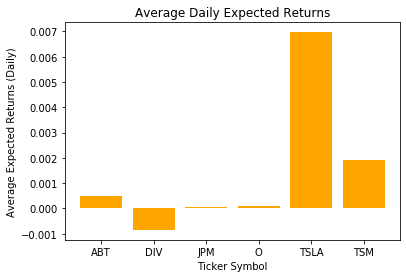

In [43]:
#Plot Average Dailey Expected Returns

plt.figure()
plt.bar(ticker, AVG_daily_ER, color = 'orange')
plt.title('Average Daily Expected Returns')
plt.xlabel('Ticker Symbol')
plt.ylabel('Average Expected Returns (Daily)')
plt.show()


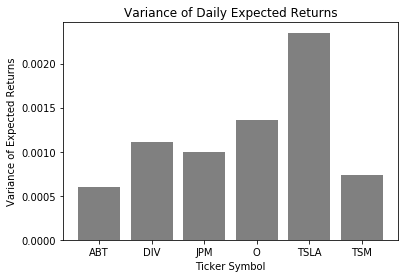

In [38]:
#Calculate and plot Variance of Returns
#Variance
variance = daily_ER.var()

#Plot
plt.figure()
plt.bar(ticker, variance, color = 'gray')
plt.title("Variance of Daily Expected Returns")
plt.xlabel('Ticker Symbol')
plt.ylabel('Variance of Expected Returns')
plt.show()

In [11]:
#Calculate Covariance
covariance = daily_ER.cov()
print(covariance)


           ABT       DIV       JPM         O      TSLA       TSM
ABT   0.000596  0.000388  0.000459  0.000401  0.000356  0.000388
DIV   0.000388  0.001109  0.000689  0.000794  0.000728  0.000418
JPM   0.000459  0.000689  0.000992  0.000792  0.000568  0.000543
O     0.000401  0.000794  0.000792  0.001363  0.000840  0.000486
TSLA  0.000356  0.000728  0.000568  0.000840  0.002351  0.000616
TSM   0.000388  0.000418  0.000543  0.000486  0.000616  0.000737


In [15]:
#Portfolio Optimization 
df_1 = return_portfolios(AVG_daily_ER, covariance)

weights, returns, risks = optimal_portfolio(daily_ER[1:])

print(weights.shape)
simp_returns = AVG_daily_ER.to_numpy().reshape(1,6)
print(simp_returns.shape)
opt_returns = np.asscalar(np.dot(simp_returns, weights))
print(opt_returns)


     pcost       dcost       gap    pres   dres
 0: -1.4492e-03 -1.0069e+00  1e+00  4e-16  3e+00
 1: -1.4628e-03 -1.6911e-02  2e-02  8e-17  4e-02
 2: -2.4534e-03 -6.9920e-03  5e-03  1e-16  1e-02
 3: -6.6071e-03 -7.9751e-03  1e-03  2e-15  3e-18
 4: -6.8438e-03 -6.8630e-03  2e-05  3e-16  3e-18
 5: -6.8517e-03 -6.8519e-03  2e-07  2e-16  3e-18
 6: -6.8518e-03 -6.8518e-03  2e-09  1e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4451e-03 -1.0069e+00  1e+00  1e-16  3e+00
 1: -1.4586e-03 -1.6904e-02  2e-02  8e-17  4e-02
 2: -2.4479e-03 -6.9826e-03  5e-03  1e-16  1e-02
 3: -6.5919e-03 -7.9582e-03  1e-03  1e-16  4e-18
 4: -6.8294e-03 -6.8487e-03  2e-05  2e-16  5e-18
 5: -6.8374e-03 -6.8376e-03  2e-07  8e-17  2e-18
 6: -6.8375e-03 -6.8375e-03  2e-09  1e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4405e-03 -1.0069e+00  1e+00  1e-16  3e+00
 1: -1.4540e-03 -1.6896e-02  2e-02  1e-16  4e-02
 2: -2.4417e-03 -6.9720e

 5: -2.1474e-03 -2.1552e-03  8e-06  1e-16  2e-18
 6: -2.1526e-03 -2.1530e-03  3e-07  2e-16  1e-18
 7: -2.1529e-03 -2.1529e-03  4e-09  1e-16  2e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.0288e-04 -1.0041e+00  1e+00  1e-16  3e+00
 1:  1.9264e-04 -1.4045e-02  1e-02  5e-17  4e-02
 2: -4.0175e-04 -3.4776e-03  3e-03  8e-17  8e-03
 3: -1.4821e-03 -2.2229e-03  7e-04  2e-16  3e-18
 4: -1.7431e-03 -1.8166e-03  7e-05  2e-16  2e-18
 5: -1.7850e-03 -1.7885e-03  3e-06  2e-16  2e-18
 6: -1.7864e-03 -1.7867e-03  3e-07  1e-16  2e-18
 7: -1.7864e-03 -1.7864e-03  9e-09  6e-17  3e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.0807e-04 -1.0037e+00  1e+00  3e-17  3e+00
 1:  3.9806e-04 -1.3690e-02  1e-02  7e-17  4e-02
 2: -1.6846e-04 -3.0776e-03  3e-03  8e-17  8e-03
 3: -1.1321e-03 -1.7415e-03  6e-04  2e-16  3e-18
 4: -1.3981e-03 -1.4586e-03  6e-05  6e-17  8e-19
 5: -1.4236e-03 -1.4250e-03  1e-06  2e-16  2e-18
 6: -1.4242e-03 -1.4242

 7:  3.4497e-02  3.4497e-02  1e-09  1e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.8906e-02 -9.8118e-01  1e+00  6e-17  3e+00
 1:  4.8153e-02  9.9715e-03  4e-02  1e-16  1e-01
 2:  4.0260e-02  3.1888e-02  8e-03  7e-17  4e-17
 3:  3.9086e-02  3.8226e-02  9e-04  6e-17  2e-17
 4:  3.8860e-02  3.8761e-02  1e-04  1e-16  2e-17
 5:  3.8826e-02  3.8821e-02  5e-06  2e-16  3e-17
 6:  3.8825e-02  3.8825e-02  8e-08  3e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.4731e-02 -9.7837e-01  1e+00  2e-16  3e+00
 1:  5.3815e-02  1.3039e-02  4e-02  9e-17  1e-01
 2:  4.5209e-02  3.6122e-02  9e-03  1e-16  3e-17
 3:  4.3959e-02  4.3061e-02  9e-04  1e-16  4e-17
 4:  4.3712e-02  4.3613e-02  1e-04  1e-16  3e-17
 5:  4.3678e-02  4.3674e-02  4e-06  1e-16  2e-17
 6:  4.3677e-02  4.3677e-02  6e-08  1e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.1205e-02 -9.7512e-01  1e+00  2e-16  3e+00


 3:  1.5790e+00  1.5788e+00  1e-04  1e-16  4e-05
 4:  1.5789e+00  1.5789e+00  4e-06  1e-16  5e-07
 5:  1.5789e+00  1.5789e+00  4e-08  6e-17  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7897e+00  6.5499e-01  1e+00  3e-16  4e+00
 1:  1.7777e+00  1.7234e+00  5e-02  6e-17  2e-01
 2:  1.7725e+00  1.7699e+00  3e-03  2e-17  4e-03
 3:  1.7717e+00  1.7716e+00  1e-04  1e-16  4e-05
 4:  1.7717e+00  1.7717e+00  3e-06  1e-16  5e-07
 5:  1.7717e+00  1.7717e+00  3e-08  1e-16  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.0041e+00  8.6973e-01  1e+00  1e-16  4e+00
 1:  1.9929e+00  1.9423e+00  5e-02  6e-17  1e-01
 2:  1.9886e+00  1.9863e+00  2e-03  1e-16  4e-03
 3:  1.9880e+00  1.9879e+00  8e-05  1e-16  4e-05
 4:  1.9880e+00  1.9880e+00  2e-06  6e-17  4e-07
 5:  1.9880e+00  1.9880e+00  2e-08  1e-16  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.2449e+00  1.1109e+00  1e+00  1e-16  4e+00


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if __name__ == '__main__':


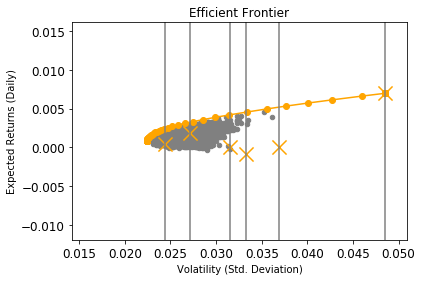

In [13]:
#Plot Efficient Frontier
df_1.plot.scatter(x = 'Volatility', y = 'Returns', fontsize = 12, color = 'gray')
plt.plot(risks, returns, 'y-o', color = 'orange')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns (Daily)')

#Single Asset portfolio markers
std = np.sqrt(np.diagonal(covariance))
plt.scatter(std, AVG_daily_ER, marker = 'x', color = 'orange', s = 200)
for xc in std:
    plt.axvline(x = xc, color = 'gray')

In [29]:
#Pick optimal portfolios

returns_tolerance = np.array([0.003, 0.010])
volatility_tolerance = np.array([0.03, 0.04])

df_lower_volatility = df_1[(df_1.Returns > returns_tolerance[0]) & (df_1.Volatility < volatility_tolerance[0])]
df_higher_returns = df_1[(df_1.Returns > returns_tolerance[1]) & (df_1.Volatility < volatility_tolerance[1])]
print(df_lower_volatility)
print(df_higher_returns)

       Returns  Volatility  ABT Weight  DIV Weight  JPM Weight  O Weight  \
544   0.003360    0.028381    0.404378    0.011942    0.034470  0.006534   
757   0.003101    0.028520    0.306640    0.029029    0.019364  0.129636   
768   0.003564    0.029853    0.174774    0.011882    0.132859  0.022485   
830   0.003016    0.028411    0.143495    0.032725    0.172606  0.059845   
1188  0.003103    0.029318    0.159788    0.014143    0.033602  0.206848   
1398  0.003128    0.029721    0.198995    0.090148    0.065876  0.122011   
1405  0.003088    0.029184    0.126027    0.002631    0.001275  0.232765   
1454  0.003370    0.029881    0.073361    0.086250    0.003327  0.109811   
1494  0.003150    0.029118    0.189335    0.081421    0.064289  0.089437   
1641  0.003221    0.029290    0.263294    0.026381    0.149420  0.060197   
1694  0.003038    0.028805    0.293741    0.015636    0.070245  0.148508   
1775  0.003035    0.029010    0.074966    0.086086    0.088371  0.104914   
2014  0.0033

In [31]:
print(df_1.iloc[3950])
print(df_1.iloc[2417])

Returns        0.003631
Volatility     0.029850
ABT Weight     0.026388
DIV Weight     0.050942
JPM Weight     0.013122
O Weight       0.019462
TSLA Weight    0.387815
TSM Weight     0.502271
Name: 3950, dtype: float64
Returns        0.003056
Volatility     0.027700
ABT Weight     0.234903
DIV Weight     0.014790
JPM Weight     0.139759
O Weight       0.024531
TSLA Weight    0.361146
TSM Weight     0.224871
Name: 2417, dtype: float64
